# Valutazione

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import tensorflow as tf
import os 
import scipy.fftpack as scipy
import onnxruntime as rt
import tf2onnx
import onnx

In [2]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split (se no darebbe errore)
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split (se no darebbe errore)
)

val_ds = validation_ds.take(validation_ds.cardinality() // 2) # ho cambiato nome del validation_ds in modo tale da non creare problemi con l'istruzione seguente
test_ds = validation_ds.skip(validation_ds.cardinality() // 2)

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.


In [3]:
class DatasetConverter:
    def __init__(self, dataset):
        self.dataset = dataset

    def convert(self, option):
        available_options = ['spectrogram', 'filterbanks', 'mfcc']
        
        if option == available_options[0]:
            return self.get_spectrogram_dataset()
        elif option == available_options[1]:
            return self.get_filterbanks_dataset()
        elif option == available_options[2]:
            return self.get_mfcc_dataset()
        else:
            raise ValueError(f"Opzione non disponibile: inserire una delle seguenti opzioni: {available_options}")
    
    # INIZIO SPETTROGRAMMI
    def squeeze(self, audio, labels):
        audio = tf.squeeze(audio, axis=-1)
        return audio, labels
    
    def get_spectrogram(self, waveform):
    # applichiamo la short-time Fourier transorm
        spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
        spectrogram = tf.abs(spectrogram)
        
        return spectrogram[..., tf.newaxis]
    
    def get_spectrogram_dataset(self):
        # squeeze
        self.dataset = self.dataset.map(self.squeeze, tf.data.AUTOTUNE)
        self.dataset = self.dataset.map(lambda x, y: (self.get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        
        return self.dataset

    # FINE SPETTROGRAMMI

    def convert_to_numpy(self, dataset):
        audio_data = []
        labels = []
    
        dataset = dataset.unbatch()
        
        for audio, label in dataset:
            audio_data.append(audio.numpy())  # Assuming audio is a tensor, convert to numpy array
            labels.append(label.numpy())      # Assuming label is a tensor, convert to numpy array
        
        audio_data = np.array(audio_data)
        labels = np.array(labels)
        
        return audio_data, labels
    
    # INIZIO FILTERBANKS
    def makeHamming(self, M):
        R = (( M - 1 ) / 2 , M / 2)[M % 2 == 0]
        w = (np.hamming(M), np.hamming(M + 1))[M % 2 == 0]
        if M % 2 != 0:
            w[0] = w[0]/2
            w[M-1] = w[M-1]/2
        else:
            w = w[:M]
    
        return w

    def hztomel(self, hz):
        return (2595 * np.log10(1 + hz / 700))

    def meltohz(self, mel):
        return (700 * (10**(mel / 2595) - 1))

    def compute_filterbanks(self, audios_np, pre_emphasis=0.97, sample_rate=16000, frame_size=0.025, frame_stride=0.01, NFFT=512, nfilt=40):
        filterbanks_np = []
        
        for samples in audios_np:
            emphasized_audio = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])
            audio_length = len(emphasized_audio)
    
            frame_length, frame_step = int(frame_size * sample_rate), int(frame_stride * sample_rate)
    
            num_frames = int(np.ceil(float(np.abs(audio_length - frame_length)) / frame_step))
    
            pad_audio_length = num_frames * frame_step + frame_length
            z = np.zeros((pad_audio_length - audio_length))
            pad_audio = np.append(emphasized_audio, z)
    
            indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
            frames = pad_audio[indices.astype(np.int32, copy=False)]
    
            # Usiamo la funzione di Hamming
            hamming_window = self.makeHamming(frame_length)
    
            mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitudo della FFT
            pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
    
            # convertiamo hz in mel
            low_freq_mel = self.hztomel(0)
            high_freq_mel = self.hztomel(sample_rate / 2)
    
            mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
            hz_points = self.meltohz(mel_points) 
    
            bin = np.floor((NFFT + 1) * hz_points / sample_rate)
    
            fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    
            for m in range(1, nfilt + 1):
                f_m_minus = int(bin[m - 1])
                f_m = int(bin[m])
                f_m_plus = int(bin[m + 1])
    
                for k in range(f_m_minus, f_m):
                    fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
                for k in range(f_m, f_m_plus):
                    fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    
            # in questo momento invece calcoliamo i filter banks per i segmenti di audio, utilizzando i filtri triangolari appena creati
            filter_banks = np.dot(pow_frames, fbank.T)
            filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
            filter_banks = 20 * np.log10(filter_banks)
    
            filterbanks_np.append(filter_banks)
        
        return np.array(filterbanks_np)
    
    def get_filterbanks_dataset(self): 
        audios, labels = self.convert_to_numpy(self.dataset)

        filterbanks = self.compute_filterbanks(audios)
        filterbanks = np.expand_dims(filterbanks, axis=-1)

        self.dataset = tf.data.Dataset.from_tensor_slices((filterbanks, labels))
        self.dataset = self.dataset.batch(32)
        
        return self.dataset
    # FINE FILTERBANKS

    # INIZIO MFCC
    def compute_mfcc(self, filter_banks, num_ceps=12, cep_lifter=22):
        mfcc_np = []
        
        for f in filter_banks:
            mfcc = scipy.dct(f, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]

            (nframes, ncoeff) = mfcc.shape
            n = np.arange(ncoeff)
            
            lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
            mfcc *= lift

            mfcc_np.append(mfcc)
        
        return np.array(mfcc_np)
    
    
    def get_mfcc_dataset(self):
        audios, labels = self.convert_to_numpy(self.dataset)

        filterbanks = self.compute_filterbanks(audios)
        mfcc = self.compute_mfcc(filterbanks)
        
        mfcc = np.expand_dims(mfcc, axis=-1)
        
        self.dataset = tf.data.Dataset.from_tensor_slices((mfcc, labels))
        self.dataset = self.dataset.batch(32)
        
        return self.dataset
    
    # FINE MFCC

In [4]:
def evaluate_onnx_model(path_model_onnx, test_ds):
    # il fatto che sia suddiviso in batch mi crea problemi, perciò lo risolvo togliendoli
    test_ds = test_ds.unbatch()
    
    # carico il modello utilizzando il file onnx
    m = rt.InferenceSession(path_model_onnx)
    
    # trasformo il dataset in array numpy
    spectrogram_np = np.array([spectrogram.numpy() for spectrogram, _ in test_ds], dtype=np.float32)
    labels_np = np.array([label.numpy() for _, label in test_ds])
    
    # eseguo le predizione del modello
    pred_onnx = m.run(None, {'input': spectrogram_np})
    # ottengo la predizione corretta
    predictions = np.argmax(pred_onnx[0], axis=1)
    # computo la accuratezza
    accuracy = np.mean(predictions == labels_np)
    # stampo l'accuratezza
    return f"{accuracy:.3f}"

In [44]:
# creiamo le colonne e il dataframe
headers = ["Modello", "Dataset", "Rumore", "Accuratezza"]

def create_table(dataset_name, optimizer="rmsprop", noise=False):
    dataset = DatasetConverter(test_ds)
    dataset = dataset.convert(dataset_name)
    
    path = f"bestmodels/noise/{optimizer}/" if noise else f"bestmodels/{optimizer}/"
    path += dataset_name + "/"

    df = pd.DataFrame(columns=headers)

    for model in os.listdir(path):
        if model.endswith("onnx"):
            new_row = []
            new_row.append(model.split(".onnx")[0])
            new_row.append(path.split("/")[-2])
            
            if noise:
                new_row.append("Sì")
            else:
                new_row.append("No")
            
            new_row.append(float(evaluate_onnx_model(path+model, dataset)))

            df.loc[-1] = new_row
            df.index = df.index + 1

    return df.sort_values(by="Accuratezza", ascending=False).reset_index(drop=True)

In [45]:
df_spect = create_table("spectrogram")
df_fb = create_table("filterbanks")
df_mfcc = create_table("mfcc")

In [52]:
def create_plot(dataframe, *args): # prende un numero imprecisato di parametri della stessa rete che vogliamo cofrontare
    value = []
    
    for arg in args:
        value.append(arg)

    # Impostare l'indice del DataFrame con la colonna 'models' per poterlo stampare nella x
    df = dataframe.set_index('Modello')[value]
    
    ax = df.plot.bar()
    
    # Ruotare le etichette dell'asse x
    ax.set_xticklabels(ax.get_xticklabels(), rotation=5)
    ax.set_yticks(np.arange(0.0, 1.2, 0.2))
    
    plt.ylabel("Valori")

    plt.show()

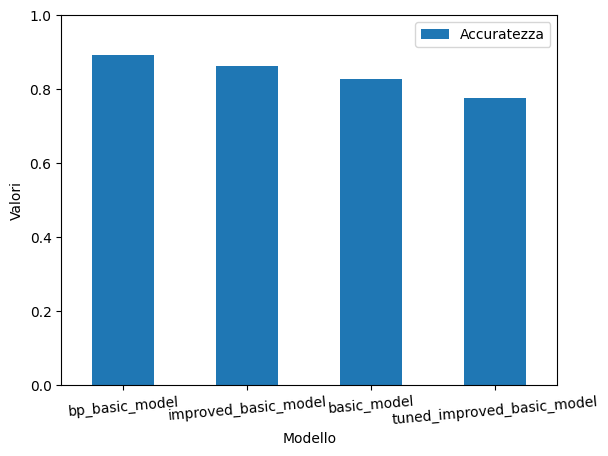

In [53]:
create_plot(df_spect, "Accuratezza")